In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
## en esta clase no vamos a modificar nada para no hacer cagada
## esto es codigo 100% de Maurette pero con comentarios mios

In [3]:
## este es el código de Maurette para cálculo de opción europea 
## usando árbol binomial
## de nuevo: con un solo # son los comentarios de él
## con ## son los míos

## parece largo, pero es puro comentario

## nota : * es multiplicación y ** es potencia. 
## es decir: 2*3 = 6 y 2**3= 8 

def opcion_europea_bin(tipo, S, K, T, r, sigma, div, pasos):

    #auxiliares
    
    ## dt: delta t, es el largo del paso que doy. Time to maturity / pasos.
    ## Lo que estamos haciendo es dividir la vida de la opción  en muchos intervalos
    ## de tiempo de tamaño dt.
    dt = T / pasos
    
    ## tasas: la tasa hacia adelante y la tasa para descontar
    ## son las continuas, e a la r*dt. La unica diferencia es que si
    ## tenes dividendos, se los restas a la risk free
    tasa_forward = math.exp((r - div) * dt)
    descuento = math.exp(-r * dt)

    #modelo CRR
    ## En cada intervalo de tiempo vamos a asumir que el precio del subyacente se puede mover
    ## hacia cualqueira de dos precios: S*u o S*d  (S es el precio)
    ## Entonces vamos a definir esos dos valores que multiplican al precio S: d y u
    ## u es lo que sube el precio de la acción y d lo que baja 
    ## en general u > 1 y d < 1. O sea: si S0 es el precio de la acción al inicio del arbol,
    ## si el precio de la acción sube (la rama de arriba) te va a quedar en s0 * u. 
    ## si el precio de la acción baja (la rama de abajo) te va a quedar en s0 * d
    
    ## Siguiendo las ecuaciones del hull (edicion 10, pagina 451. Ecuaciones 21.3 a 21.7)
    u = math.exp(sigma * math.pow(dt, 0.5))  ## ecuacion 21.5
    d = 1 / u ## ecuacion 21.3
    
    #probabilidad de riesgo neutral 
    ## cual es la probabilidad en un mundo risk-neutral de que la acción suba
    ## en el hull (edicion 10, pagina 285) muestra que esta tambien es la proba en el mundo real
    ## ademas de la proba en el mundo risk-neutral
    q_prob = (tasa_forward - d) / (u - d) ## ecuacion 21.4

    #Precios finales
    ## instancia una vector de 0 del tamaño de los pasos + 1
    ## aca va a guardar los precios finales de la acción
    ST_precios=np.zeros((pasos+1))
    
    ## y acá genera los precios finales de la acción
    ## lo que está haciendo es generar potencias de u
    ## ponele que hay 4 pasos: 
    ## 2 * i - pasos te va a generar los siguientes valores:
    ## 2*0 - 4 = -4
    ## 2*1 -4 = -2
    ## 2*2 - 4 = 0
    ## 2*3 - 4 = 2 
    ## 2*4 - 4 = 4
    ## si miras la pagina 452 del hull (edicion 10), figura 21.2 
    ## son los valores del ultimo timestep
    ## el detalle a tener en cuenta es que d = 1/u
    ## entonces ese u ** -2 es como tener d ** 2
    for i in range(0,pasos+1):
        ST_precios[pasos-i] = math.pow(u, 2 * i - pasos) * S
        
    
    ## aca va a generar una matriz de 0 para guardar los precios
    ## de las opciones
    #Matriz de precios de la opcion
    opcion_precios = np.zeros((pasos+1, pasos+1))
    
    ## calculamos el valor de las opciones sobre los precios finales
    #Payoff
    for i in range (0, pasos+1):
        if tipo == "P":
            ## si es un put, para el precio final de las opciones calculamos
            ## el maximo entre 0 y la diferencia entre K (el strike) y el 
            ## precio de la acción que calculamos antes
            opcion_precios[i][pasos] = max(0, (K - ST_precios[i]))
        elif tipo == "C":
            ## si es un call, para el precio final de las opciones calculamos
            ## el maximo entre 0 y la diferencia entre el precio de la acción que calculamos antes
            ## y K (el strike)
            opcion_precios[i][pasos] = max(0, (ST_precios[i] - K))
    
    ## ahora ya tenemos el precio final de las acciones y de las opciones
    ## lo que hacemos es ir para atrás por el arbol y lo vamos completando.
    ## en este caso, Maurette lo representa con una matriz (que va a quedar esparsa)
    
    for j in range(1, pasos+1):
        for i in range(0, pasos+1 - j):
            ## arranca de arriba a la derecha de la matriz y se va moviendo
            ## hacia abajo (i) y hacia izquierda (j)
            
            ## aca hay una formula medio larga:
            ## hace el descuento una suma:
            ## (q_prob * opcion_precios[i][pasos - j + 1] + (1  - q_prob) * opcion_precios[i + 1][pasos - j + 1])
            ## el primer termino de la suma es q_prob (que dijimos que es la proba risk-neutral de que la accion suba)
            ## multiplicado por opcion_precios[i][pasos - j + 1], o sea que lo que hace es tomar la misma fila
            ## y mirar el numero de la derecha. O sea, lo que está viendo es el precio de la opción si el subyacente sube
            ## y del otro lado tenemos 1 - qprob (o sea, la probabilidad risk-neutrla de que le subyacente baje)
            ## multiplicado por el precio de la opcion si el subyacente baja (o sea, el numero que esta a la derecha
            ## y en la fila de abajo de la matriz de precios de opciones)
            ## o sea, que lo que tenes ahi es:
            ## precio de la opcion si sube el subyacente * probabilidad de que suba + precio de la opcion si el subyacente
            ## baja * probabilidad de que baje (la esperanza)
            ## y eso lo multiplica por la tasa de descuento
            
            ## con eso se va moviendo para atrás en la matriz de precios de opciones y va completando la matriz de 0
            ## arranca con los precios de adelante, calcula la esperanza y descuenta, luego se mueve para atras y repite
            
            opcion_precios[i][pasos - j] = descuento * (q_prob * opcion_precios[i][pasos - j + 1] + (1  - q_prob) * opcion_precios[i + 1][pasos - j + 1])

    ## la opcion del principio de todo es el precio que deberia tener la opcion
    precio_BIN = opcion_precios[0][0]
    return precio_BIN



In [4]:
## tenemos la otra funcion: el calculo de precio para opciones americanas
def opcion_americana_bin(tipo, S, K, T, r, sigma, div, pasos):

    ## la priemra parte es IGUAL (se podria escribir una sola funcion que abarque ambos tipos)
    dt = T / pasos
    tasa_forward = math.exp((r - div) * dt)
    descuento = math.exp(-r * dt)
    u = math.exp(sigma * math.pow(dt, 0.5))
    d = 1 / u
    q_prob = (tasa_forward - d) / (u - d)

    #Precios finales
    ST_precios=np.zeros((pasos+1))

    for i in range(0,pasos+1):
        ST_precios[pasos-i] = math.pow(u, 2 * i - pasos) * S

    #Matriz de Opcion
    opcion_precios = np.zeros((pasos+1, pasos+1))

    #Payoff
    for i in range (0, pasos+1):
        if tipo == "P":
            opcion_precios[i][pasos] = max(0, (K - ST_precios[i]))
        elif tipo == "C":
            opcion_precios[i][pasos] = max(0, (ST_precios[i] - K))
    
    
    ## hasta aca todo igual, acá es donde arranca la diferencia
    for j in range(1, pasos+1):
        for i in range(0, pasos+1 - j):
            
            ## calcula el precio como si fuera una europea (igual que en la funcion anterior)
            eur = q_prob * opcion_precios[i][pasos - j + 1] + (1  - q_prob) * opcion_precios[i + 1][pasos - j + 1]
            if tipo == "P":
                ## si es un put, se queda con el máximo entre el precio de la europea correspondiente
                ## y K (el strike) - el S que tendrías en ese tiempo. O sea, te quedas con el mejor
                ## entre el precio y lo que te queda si la ejercés
                ## eso lo descontas
                opcion_precios[i][pasos - j] = descuento * max(eur, K - S * math.pow(u,-2*i+pasos-j))
            elif tipo == "C":
                ## lo mismo para el call: es el maximo entre la europea y el ejercicio, descontado
                opcion_precios[i][pasos - j] = descuento * max(eur, S * math.pow(u,-2*i+pasos-j) - K)
    
    ## hay que tener en cuenta que, aunque estamos tomando un parámetro para dividendos al principio del código
    ## despues no se corrije por dividendos en el cálculo del árbol. 
    ## igual maurette aclaró que para hacer codigo productivo en vez de usar esto, es recomendable usar
    ## quantlib
    
    return opcion_precios[0][0]

In [5]:
#Paramtros del metodo

## hagamos un ejemplo con una europea:
tipo = "C" ## es un put
S = 10 ## con precio actual 10
K = 7 ## strike 7
T = 4 ## time to maturity
r = 0.05 ## risk free 
sigma = 0.25 ## volatilidad
div = 0 ## sin dividendos
pasos = 30 ## el hull dice que con 30 pasos alcanza (i choose to believe)


precio = opcion_europea_bin(tipo, S, K, T, r, sigma, div, pasos)
precio

4.511737946878427

In [6]:
## y si fuera americana:
precio = opcion_americana_bin(tipo, S, K, T, r, sigma, div, pasos)
precio

4.511737946878427

In [7]:
## acá va a implementar de otra manera, más rápida, el arbol binomial
## esta es la formula cerrada que vemos en clase 3 diapo 32

import operator as op
from functools import reduce

## aca define una funcion para calcular las combinaciones de n tomadas de a r
## por ejemplo ncr(4,2) sería las combinaciones de 4 tomadas de a 2 
## o sea 6
## esta funcion es una forma rápida de calcularlo nada mas:
def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1) 
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom 


def opcion_europea_bin_c(tipo, S, K, T, r, sigma, div, pasos):
    
    ## al principio es igual
    
    #auxiliares
    dt = T / pasos
    tasa_forward = math.exp((r - div) * dt)
    descuento = math.exp(-r * dt)

    #modelo CRR
    u = math.exp(sigma * math.pow(dt, 0.5))
    d = 1 / u
    #probabilidad de riesgo neutral
    q_prob = (tasa_forward - d) / (u - d)

    ## aca es donde empieza a ser diferente
    ## define una variable temp
    ## esto es un acumulador donde va a ir sumandole cosas
    ## sirve para hacer una sumatoria
    temp = 0
    
    ## itera sobre los pasos (en vez de del r de la funcion auxiliar ncr se va a llamar k)
    for k in range(pasos):
        if tipo == "C":
            ## aca calcula el payoff para el último tiempo. 
            ## supongamos que tenes 4 pasos:
            ## Cuando k = 0, te queda max(0, S * 1 * d**4 - K)
            ## Cuando k = 1, te queda max(0, S * u * d**3 - K)
            ## Cuando k = 2, te queda max(0, S * (u**2) * (d**2) - K)
            ## Cuando k = 3, te queda max(0, S * (u**3) * (d) - K)
            
            ## me parece que falta un paso más, pero k itera en range(pasos)
            ## o sea que si pasos = 4, range(pasos) vale 0,1,2,3
            ## por ahi habría que corregirlo a range(pasos+1)
            
            ## o sea, te vas moviendo desde el caso en el que el precio de la acción bajó
            ## en todos los pasos. Despues al que bajó en todos los pasos menos 1 y subio en 1. 
            ## DEspues al que bajó en todos los pasos menos 2 de ellos y subio en dos pasos
            ## y así hasta el caso en que el precio de la acción subió en todos los pasos
            
            payoff = max(0, S * math.pow(u,k) * math.pow(d,pasos-k)-K)
        elif tipo == "P":
            
            ## lo mismo para el put, pero con su payoff
            payoff = max(0, K - S * math.pow(u, k) * math.pow(d, pasos - k))
        
        ## y le suma a temp 
        ## aca a temp le va sumando el valor del combinatorio
        ## multiplicado por la probabilidad de llegar al nodo en el que está
        ## por el payoff correspondiente
        ## (ver segunda ecuacion de la diapo 32 de la clase 3 del modulo de Maurette)
        temp = temp +ncr(pasos, k) * math.pow(q_prob,k) * math.pow((1-q_prob),pasos-k) * payoff
    
    ## y lo que le queda, lo descuenta
    precio_BIN_c = math.exp(-r*T)*temp
    return precio_BIN_c


#### Graficos

In [8]:
## va a generar una serie de graficos moviendo una sola cosa y dejando todo lo demás igual
## la logica es siempre la misma: defino una serie de parámetros (volatilidad, strike, precio del subyacente, etc)
## y muevo uno solo. Voy viendo precios de la opcion para ese valor que muevo.
## por ejemplo: evaluo el precio de una opcion con una volatilidad del 1%, del 2%, del 3% ..., del 10% y asi
## dejando strike, precio del subyacente y todo lo demás quieto.

In [9]:
## ahora va a graficar el precio de una opcion respecto del precio del subyacente
## va a generar una serie de precios de la accion para el eje x 
## en el eje y va a poner el precio de la opcion

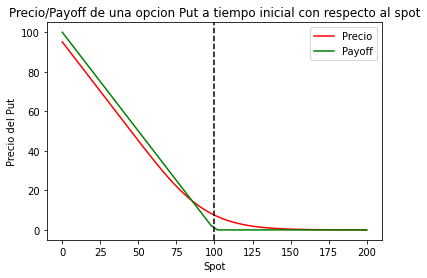

In [10]:
## define un put con strike 100, precio 100, time to maturity = 1
## risk free de 5%, volatilidad del 25%, sin dividendos,
## con 100 pasos:
tipo = "P"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0
pasos = 1000


## va a hacer un gráfico nomás
S_MAX = 2*S  # va a graficar hasta 2 veces el precio del subyacente
## o sea, que si sale 100, va a graficar de 0 a 200 en el eje x
S_vec = np.linspace(0,S_MAX,50) ## genera un vector de 0 a 2*S (esto es para el eje X)
## serian los precios finales de la accion

precios = np.zeros(len(S_vec)) ## y define un vector de 0 para guardar los precios

payoff = np.zeros(len(S_vec)) ## define el payoff con un vector de 0

## y va guardando los precios del put que definimos arriba de todo, para cada precio final
## que definimos en S_vec
for index in range(len(S_vec)):
    precios[index] = opcion_europea_bin_c(tipo, S_vec[index], K, T, r, sigma, div, pasos) ## el precio de la opcion
    payoff[index] = max(0, K-S_vec[index]) ## el payoff de la opcion

## y despues solo plotea    
plt.plot(S_vec,precios,'r', label='Precio')
plt.plot(S_vec,payoff,'g', label='Payoff')
plt.axvline(x=K, color = 'black', linestyle='--')

plt.legend()

plt.xlabel('Spot')
plt.ylabel('Precio del Put')
plt.title('Precio/Payoff de una opcion Put a tiempo inicial con respecto al spot')

plt.show()

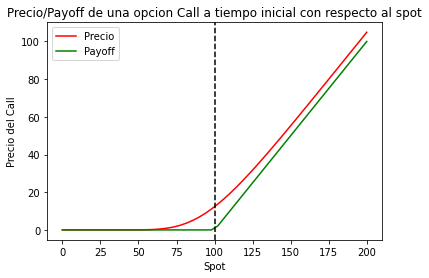

In [11]:
## lo mismo con un call
tipo = "C"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0
pasos = 1000



S_MAX = 2*S
S_vec = np.linspace(0,S_MAX,50)      
precios = np.zeros(len(S_vec))
payoff = np.zeros(len(S_vec))

for index in range(len(S_vec)):
    precios[index] = opcion_europea_bin_c(tipo, S_vec[index], K, T, r, sigma, div, pasos)
    payoff[index] = max(0, S_vec[index]-K)
plt.plot(S_vec,precios,'r', label='Precio')
plt.plot(S_vec,payoff,'g', label='Payoff')
plt.axvline(x=K, color = 'black', linestyle='--')

plt.legend()

plt.xlabel('Spot')
plt.ylabel('Precio del Call')
plt.title('Precio/Payoff de una opcion Call a tiempo inicial con respecto al spot')

plt.show()

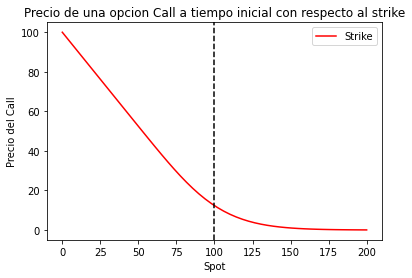

In [12]:
## ahora lo mismo, pero en vez de mover el precio del subyacente
## va a mover el valor del strike

tipo = "C"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0
pasos = 1000

K_MAX = 2*S
K_vec = np.linspace(0,K_MAX,50) ## aca genera valores para el strike
precios = np.zeros(len(K_vec))



## va iterando sobre valores del strike y calculando el precio de la opcion
for index in range(len(K_vec)):
    precios[index] = opcion_europea_bin_c(tipo, S, K_vec[index], T, r, sigma, div, pasos)

## y grafica
plt.plot(K_vec,precios,'r', label='Strike')
plt.axvline(x=S, color = 'black', linestyle='--')

plt.legend()

plt.xlabel('Spot')
plt.ylabel('Precio del Call')
plt.title('Precio de una opcion Call a tiempo inicial con respecto al strike')

plt.show()

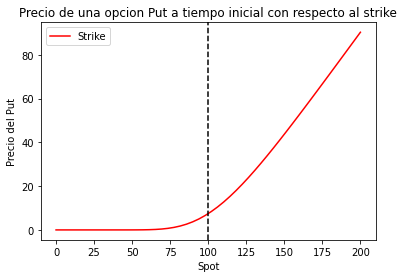

In [13]:
## lo mismo para una put

tipo = "P"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0
pasos = 1000

K_MAX = 2*S
K_vec = np.linspace(0,K_MAX,50)      
precios = np.zeros(len(K_vec))
payoff = np.zeros(len(K_vec))




for index in range(len(K_vec)):
    precios[index] = opcion_europea_bin_c(tipo, S, K_vec[index], T, r, sigma, div, pasos)

plt.plot(K_vec,precios,'r', label='Strike')
plt.axvline(x=S, color = 'black', linestyle='--')

plt.legend()

plt.xlabel('Spot')
plt.ylabel('Precio del Put')
plt.title('Precio de una opcion Put a tiempo inicial con respecto al strike')

plt.show()

In [14]:
## ahora lo mismo, pero en vez de tocar el precio del subyacente
## o el strike va a ir moviendo la volatilidad
## en teoria habiamos visto que a mayor volatilidad, mas alto el precio 

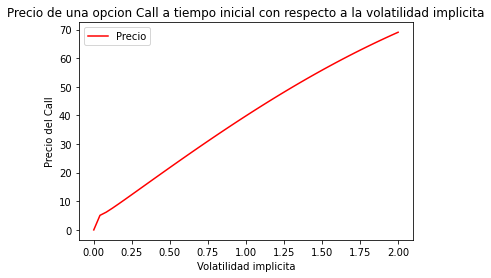

In [15]:
tipo = "C"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0
pasos = 1000

sigma_MAX = 8*sigma
sigma_vec = np.linspace(0,sigma_MAX,50) ## genera vector de posibles volatilidades
precios = np.zeros(len(sigma_vec))

for index in range(1,len(sigma_vec)):
    ## calcula el precio de la opcion segun volatilidad
    precios[index] = opcion_europea_bin_c(tipo, S, K, T, r, sigma_vec[index], div, pasos)
plt.plot(sigma_vec,precios,'r', label='Precio')
plt.legend()

plt.xlabel('Volatilidad implicita')
plt.ylabel('Precio del Call')
plt.title('Precio de una opcion Call a tiempo inicial con respecto a la volatilidad implicita')

plt.show()

## taraaaan:

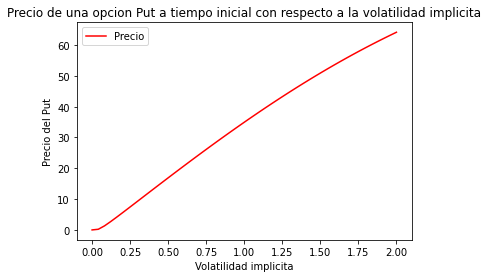

In [16]:
## lo mismo con una put

tipo = "P"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0
pasos = 1000

sigma_MAX = 8*sigma
sigma_vec = np.linspace(0,sigma_MAX,50)      
precios = np.zeros(len(sigma_vec))

for index in range(1,len(sigma_vec)):
    precios[index] = opcion_europea_bin_c(tipo, S, K, T, r, sigma_vec[index], div, pasos)
plt.plot(sigma_vec,precios,'r', label='Precio')
plt.legend()

plt.xlabel('Volatilidad implicita')
plt.ylabel('Precio del Put')
plt.title('Precio de una opcion Put a tiempo inicial con respecto a la volatilidad implicita')

plt.show()

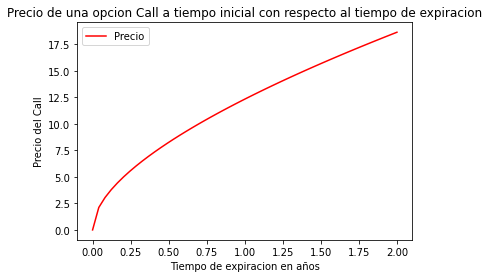

In [17]:
## y lo mismo con el time to maturity: va a ir graficando como queda el precio
## con distintos ttm
tipo = "C"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0
pasos = 1000

T_MAX = 2*T
T_vec = np.linspace(0,T_MAX,50)      
precios = np.zeros(len(T_vec))

for index in range(1,len(T_vec)):
    precios[index] = opcion_europea_bin_c(tipo, S, K, T_vec[index], r, sigma, div, pasos)
plt.plot(T_vec,precios,'r', label='Precio')
plt.legend()

plt.xlabel('Tiempo de expiracion en años')
plt.ylabel('Precio del Call')
plt.title('Precio de una opcion Call a tiempo inicial con respecto al tiempo de expiracion')

plt.show()

#### Convergencia del arbol binomial

In [18]:
tipo = "C"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0

## generamos un vector de pasos
pasos_vec = [1,2,3,4,5,6,7,8,9,10,15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]      
precios = np.zeros(len(pasos_vec))

## y para cada cantidad de pasos, calculamos el precio de la opcion:
## o sea, calculamos (con los parámetros de arriba) el precio
## usando un arbol de 1 paso y guardamos el precio
## con 2 pasos y guardamos el precio
## con 3 pasos... etc 
for index in range(len(pasos_vec)):
    precios[index] = opcion_europea_bin(tipo, S, K, T, r, sigma, div, pasos_vec[index])

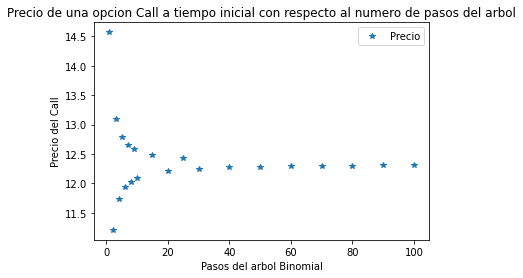

In [19]:
## y lo que vemos es que a partir de mas o menos 30 pasos, medio que se estabiliza el valor de la opcion

plt.plot(pasos_vec,precios,'*', label='Precio')
plt.legend()

plt.xlabel('Pasos del arbol Binomial')
plt.ylabel('Precio del Call')
plt.title('Precio de una opcion Call a tiempo inicial con respecto al numero de pasos del arbol')

plt.show()

#### Europeas vs Americanas

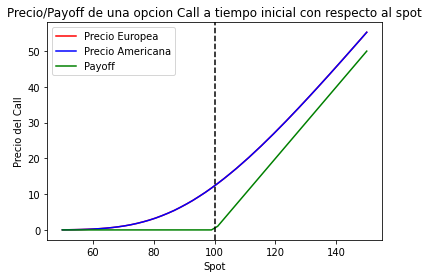

Precio Opcion Europea:  12.323646460707344
Precio Opcion Americana:  12.323646460707344


In [20]:
## define un call 
tipo = "C"
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0
pasos = 200

## genera una serie de precios de subyacentes y dos vectores para guardar precios de europeas y americanas
S_vec = np.linspace(0.5*S,1.5*S,50)      
precios_eur = np.zeros(len(S_vec))
precios_ame = np.zeros(len(S_vec))

payoff = np.zeros(len(S_vec))

## va iterando sobre los precios posibles del subyacente y calcula el precio de la opción
for index in range(len(S_vec)):
    precios_eur[index] = opcion_europea_bin(tipo, S_vec[index], K, T, r, sigma, div, pasos)
    precios_ame[index] = opcion_americana_bin(tipo, S_vec[index], K, T, r, sigma, div, pasos)
    ## y el payoff del call
    payoff[index] = max(0, S_vec[index]-K)

## plotea los precios de las americanas y de las europeas
## en el grafico se van a superponer ambas lineas, por lo que solamente vamos a ver 1!
plt.plot(S_vec,precios_eur,'r', label='Precio Europea')
plt.plot(S_vec,precios_ame,'b', label='Precio Americana')

plt.plot(S_vec,payoff,'g', label='Payoff')
plt.axvline(x=K, color = 'black', linestyle='--')

plt.legend()

plt.xlabel('Spot')
plt.ylabel('Precio del Call')
plt.title('Precio/Payoff de una opcion Call a tiempo inicial con respecto al spot')

plt.show()

## aca confirmamos que la americana y la europea valen lo mismo!
print("Precio Opcion Europea: ", opcion_europea_bin(tipo, S, K, T, r, sigma, div, pasos))
print("Precio Opcion Americana: ", opcion_americana_bin(tipo, S, K, T, r, sigma, div, pasos))

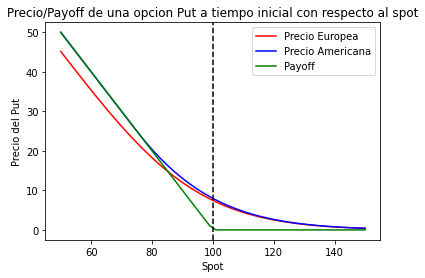

Precio Opcion Europea:  7.446588910777644
Precio Opcion Americana:  7.967099044079217


In [21]:
## lo mismo pero para el put:
## aca vamos a ver que si hay una diferencia entre los precios
## porque hay veces que es optimo ejercer un put antes de la expiracion 
## mientras que en un call no pasa

tipo = "P"

precios_eur = np.zeros(len(S_vec))
precios_ame = np.zeros(len(S_vec))

payoff = np.zeros(len(S_vec))

for index in range(len(S_vec)):
    precios_eur[index] = opcion_europea_bin(tipo, S_vec[index], K, T, r, sigma, div, pasos)
    precios_ame[index] = opcion_americana_bin(tipo, S_vec[index], K, T, r, sigma, div, pasos)
    
    payoff[index] = max(0, K -S_vec[index])

plt.plot(S_vec,precios_eur,'r', label='Precio Europea')
plt.plot(S_vec,precios_ame,'b', label='Precio Americana')

plt.plot(S_vec,payoff,'g', label='Payoff')
plt.axvline(x=K, color = 'black', linestyle='--')

plt.legend()

plt.xlabel('Spot')
plt.ylabel('Precio del Put')
plt.title('Precio/Payoff de una opcion Put a tiempo inicial con respecto al spot')

plt.show()


print("Precio Opcion Europea: ", opcion_europea_bin(tipo, S, K, T, r, sigma, div, pasos))
print("Precio Opcion Americana: ", opcion_americana_bin(tipo, S, K, T, r, sigma, div, pasos))


#### Black and Scholes

In [22]:
## defino los parámetros de una call
tipo = "C"
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0

In [23]:
## esto no tiene mucho misterio: es la formula de black and scholes
## es una cuenta nomás
## lo unico por ahi a tener en cuenta es norm.cdf es la normal acumulada

def opcion_europea_bs(tipo, S, K, T, r, sigma, div):
    #Defino los ds
    d1 = (math.log(S / K) + (r - div + 0.5 * sigma * sigma) * T) / sigma / math.sqrt(T)
    d2 = (math.log(S / K) + (r - div - 0.5 * sigma * sigma) * T) / sigma / math.sqrt(T)

    if (tipo == "C"):
        precio_BS = math.exp(-div*T) *S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
        
    elif (tipo == "P"):
        precio_BS = K * math.exp(-r * T) * norm.cdf(-d2) - math.exp(-div*T) * S * norm.cdf(-d1)
        
    return precio_BS

In [24]:
## aca va a comparar black and scholes contra el arbol binomial
## pero contra distintas cantidades de steps del arbol
## y lo que ves es que cuando tenes suficientes pasos, convergen

tipo = "P"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0.2

## aca es igual que en el grafico de mas arriba: vamos a graficar distintas cantidades de pasos
pasos_vec = [1,2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,40,50,75,100,125,150,200,250,300]      
precios = np.zeros(len(pasos_vec))

## calculo el precio de la opcion para cada uno de los pasos. Igual que antes:
## calculo el precio de la opcion para un arbol de 1 step, para un arbol de 2 steps... etc
for index in range(len(pasos_vec)):
    precios[index] = opcion_europea_bin(tipo, S, K, T, r, sigma, div, pasos_vec[index])

## y calculo el precio usando black and scholes
precio_BS = opcion_europea_bs(tipo, S, K, T, r, sigma, div)



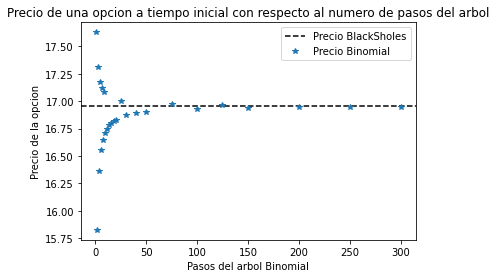

In [25]:
## y acá graficamos en negro el precio de black and scholes con una linea punteada
plt.axhline(y=precio_BS, color = 'black', linestyle='--', label='Precio BlackSholes')

## y el precio de los arboles con distintos steps, con estrellitas
plt.plot(pasos_vec,precios,'*', label='Precio Binomial')

plt.legend()

plt.xlabel('Pasos del arbol Binomial')
plt.ylabel('Precio de la opcion')
plt.title('Precio de una opcion a tiempo inicial con respecto al numero de pasos del arbol')

plt.show()

#### Mercado y Modelo

In [26]:
## a esta parte le voy a pegar una ligera reescritura

In [27]:
## esto es el codigo de "Clase2" pasado a .py
import option_data as od

In [28]:
## bajo la data de galicia
ticker = "GGAL"
panel_opciones = od.generar_df_opciones(ticker)
panel_opciones = od.get_full_data(panel_opciones)

In [29]:
panel_opciones.head()

,Especie,Ticker,Spot,CallPut,Strike,TTM,Last,Bid,Ask,impliedVolatility,Moneyness
0,GGAL210820C00005000,GGAL,8.21,C,5.0,13,4.30,2.50,3.10,0.000010,1.642000
1,GGAL210820C00007500,GGAL,8.21,C,7.5,13,0.75,0.65,1.10,0.726565,1.094667
2,GGAL210820C00010000,GGAL,8.21,C,10.0,13,0.05,0.00,0.05,0.648441,0.821000
3,GGAL210820C00012500,GGAL,8.21,C,12.5,13,0.10,0.00,0.55,2.054692,0.656800
4,GGAL210917C00007500,GGAL,8.21,C,7.5,41,0.90,0.90,1.20,0.603520,1.094667


In [31]:
# Tomo los TTMs y me quedo con alguno de ellos
TTM = panel_opciones.TTM.unique()[2]
TTM

69

In [32]:
# elijo un tipo de opcion y tomo los strikes
CP = "P"

## voy a subsetear las opciones que cumplen mis dos criterios: que tengan un TTM igual al que definimos arriba
## y que sea PUT
opciones_a_considerar = panel_opciones[(panel_opciones.TTM == TTM) & (panel_opciones.CallPut == CP)]

In [33]:
opciones_a_considerar

,Especie,Ticker,Spot,CallPut,Strike,TTM,Last,Bid,Ask,impliedVolatility,Moneyness
34,GGAL211015P00002500,GGAL,8.21,P,2.5,69,0.25,0.00,0.05,1.390628,3.284000
35,GGAL211015P00005000,GGAL,8.21,P,5.0,69,0.10,0.00,0.20,0.855470,1.642000
36,GGAL211015P00007500,GGAL,8.21,P,7.5,69,0.42,0.25,0.85,0.632816,1.094667
37,GGAL211015P00010000,GGAL,8.21,P,10.0,69,1.94,1.95,2.50,0.707034,0.821000
38,GGAL211015P00012500,GGAL,8.21,P,12.5,69,2.80,3.80,4.50,0.820314,0.656800


In [34]:
## voy a buscar la opcion mas at the money que haya:

## calculo el valor absoluto de la diferencia entre spot y strike
pos_min_dif_spot_strike = np.abs(opciones_a_considerar.Strike - opciones_a_considerar.Spot).argmin()

## y me quedo con la fila que tiene la diferencia mas chica
mi_opcion = opciones_a_considerar.iloc[pos_min_dif_spot_strike,:]

In [35]:
# Saco de los datos de mercado los parametros necesarios para pricear

S = mi_opcion.Spot
K = mi_opcion.Strike
T = (TTM)/365.25 ## Divido el TTM por 365.25 para pasar a dias

sigma = mi_opcion.impliedVolatility ## tomo la volatilidad implicita
div = 0
pasos = 100 

#tasa libre de riesgo de Libor1M - https://www.global-rates.com/en/interest-rates/libor/libor.aspx
r = 0.0009  #Libor1M** ## esto queda del codigo de Maurette 

In [36]:
# Llamo a los 2 pricers y comparo con el precio de mercado

## calcula el precio usando el arbol binomial para americanas
precio_modelo_bin = opcion_americana_bin(CP, S, K, T, r, sigma, div, pasos)
print("Precio Modelo Binomial: ", precio_modelo_bin)

## calcula el precio usando black and scholes
precio_modelo_bs = opcion_europea_bs(CP, S, K, T, r, sigma, div)
print("Precio Modelo BS: ", precio_modelo_bs)

## tomo el ultimo precio (Last)
precio_mercado_last = mi_opcion.Last

## promedio entre bid y ask (Avg)
precio_mercado_avg = (mi_opcion.Bid + mi_opcion.Ask)/2 

print("Precio Mercado Last: ", precio_mercado_last)

print("Precio Mercado Avg: ", precio_mercado_avg)



Precio Modelo Binomial:  0.5510402578183612
Precio Modelo BS:  0.5493790069045419
Precio Mercado Last:  0.42
Precio Mercado Avg:  0.55


In [37]:
## casi nada de error!
print("Error relativo entre modelo y mercado (en %): ", (precio_mercado_avg-precio_modelo_bs)/precio_mercado_avg*100)

Error relativo entre modelo y mercado (en %):  0.11290783553784645
